<a href="https://colab.research.google.com/github/Qgly33/PPPO_Projekat_IT39-2021_Robert_Kugli/blob/main/ADM_Projekat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import networkx as nx
    import requests
except ImportError:
    !pip install networkx requests pandas matplotlib numpy

from networkx.algorithms import community as nx_comm
import requests
import json
import pandas as pd
import time
import shutil
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from pathlib import Path
from google.colab import files
import os

In [ ]:
API_KEY = "5a487c5aeef811e2c26ffb8bc4016b4e"
BASE_URL = "https://api.themoviedb.org/3"
TOP_N_CAST = 8
START_DATE = '2015-01-01'
END_DATE = '2025-12-31'

BASE_PATH = Path.cwd()
RAW_DIR = BASE_PATH / "data_raw"
PROC_DIR = BASE_PATH / "data_processed"
NOTEBOOKS_DIR = BASE_PATH / "notebooks"
FIG_DIR = BASE_PATH / "figures"

RAW_DIR.mkdir(exist_ok=True)
PROC_DIR.mkdir(exist_ok=True)
NOTEBOOKS_DIR.mkdir(exist_ok=True)
FIG_DIR.mkdir(exist_ok=True)

In [ ]:
def get_movies(page=1):
    url = f"{BASE_URL}/discover/movie"
    params = {
        "api_key": API_KEY,
        "with_original_language": "sr",
        "region": "RS",
        "primary_release_date.gte": START_DATE,
        "primary_release_date.lte": END_DATE,
        "page": page
    }
    response = requests.get(url, params=params)
    return response.json()

In [ ]:
def get_movie_credits(movie_id):
    url = f"{BASE_URL}/movie/{movie_id}/credits"
    try:
        response = requests.get(url, params={"api_key": API_KEY}, timeout=10)
        return response.json()
    except:
        return {"cast": []}

In [ ]:
# --------------------------------------------------
# PREUZIMANJE SVIH DOMAĆIH FILMOVA
# --------------------------------------------------

movies = []

first_page = get_movies(page=1)
total_pages = first_page["total_pages"]

for page in range(1, total_pages + 1):
    data = get_movies(page)
    movies.extend(data["results"])
    time.sleep(0.25)

movies_df = pd.DataFrame(movies)
movies_df.to_csv(RAW_DIR / "movies_raw.csv", index=False)

print(f"Ukupno filmova: {len(movies_df)}")


Ukupno filmova: 970


In [ ]:
# --------------------------------------------------
# PREUZIMANJE GLUMAČKE POSTAVE
# --------------------------------------------------

movie_cast = {}

for movie in movies:
    movie_id = movie["id"]
    credits = get_movie_credits(movie_id)

    cast = credits.get("cast", [])[:TOP_N_CAST]

    movie_cast[movie_id] = [
        (actor["id"], actor["name"]) for actor in cast
    ]

    time.sleep(0.4)

    raw_cast_rows = []
for movie_id, cast in movie_cast.items():
    for actor_id, actor_name in cast:
        raw_cast_rows.append({"movie_id": movie_id, "actor_id": actor_id, "actor_name": actor_name})

pd.DataFrame(raw_cast_rows).to_csv(RAW_DIR / "movie_cast_raw.csv", index=False)


In [ ]:
# --------------------------------------------------
# FORMIRANJE SARADNJI (IVICA)
# --------------------------------------------------

edges = []

for cast in movie_cast.values():
    actor_ids = [actor[0] for actor in cast]
    for a, b in combinations(actor_ids, 2):
        edges.append((a, b))

edges_df = pd.DataFrame(edges, columns=["source", "target"])
edges_df.to_csv(PROC_DIR / "edges.csv", index=False)

edge_weights = edges_df.value_counts().reset_index(name="weight")
edge_weights.to_csv(PROC_DIR / "edges_weighted.csv", index=False)

unique_actors = {actor for cast in movie_cast.values() for actor in cast}
nodes_df = pd.DataFrame(unique_actors, columns=["actor_id", "name"])
nodes_df.to_csv(PROC_DIR / "nodes.csv", index=False)


In [ ]:
# --------------------------------------------------
# FORMIRANJE ČVOROVA (GLUMCI)
# --------------------------------------------------

unique_actors = {}
for movie_id, cast in movie_cast.items():
    for actor_id, actor_name in cast:
        unique_actors[actor_id] = actor_name

nodes_df = pd.DataFrame(list(unique_actors.items()), columns=["actor_id", "name"])
nodes_df.to_csv(PROC_DIR / "nodes.csv", index=False)
print(f"👥 Čvorovi kreirani: {len(nodes_df)} glumaca.")

👥 Čvorovi kreirani: 2762 glumaca.


In [ ]:
# --------------------------------------------------
# TEŽINE SARADNJI
# --------------------------------------------------
edge_weights = edges_df.value_counts().reset_index(name="weight")
edge_weights.to_csv(PROC_DIR / "edges_weighted.csv", index=False)
print(f"🔗 Ivice kreirane: {len(edge_weights)} jedinstvenih saradnji.")

🔗 Ivice kreirane: 12950 jedinstvenih saradnji.


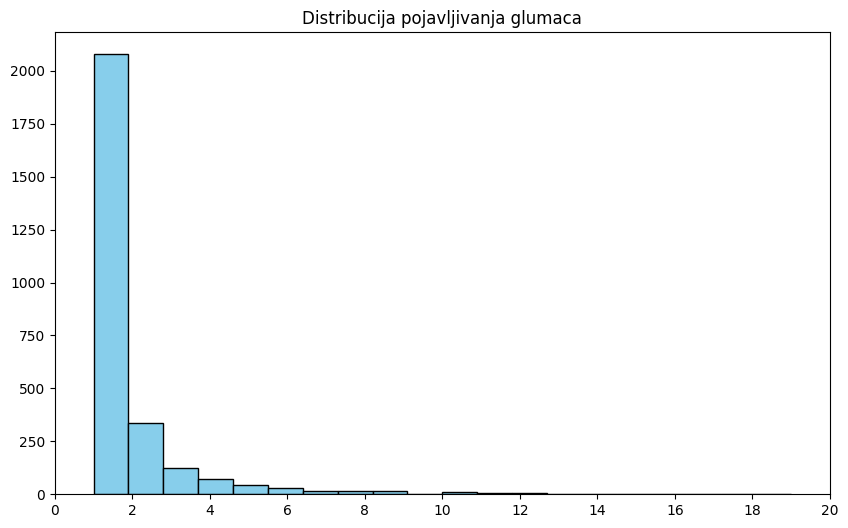

In [ ]:
# --------------------------------------------------
# OSNOVNE STATISTIKE
# --------------------------------------------------

all_actor_ids = [row['actor_id'] for row in raw_cast_rows]
actor_appearances = pd.Series(all_actor_ids).value_counts().reset_index()
actor_appearances.columns = ["actor_id", "num_movies"]
actor_appearances.to_csv(PROC_DIR / "actor_appearances.csv", index=False)

# Histogram
plt.figure(figsize=(10, 6))
plt.hist(actor_appearances["num_movies"], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribucija pojavljivanja glumaca")
plt.savefig(FIG_DIR / "histogram.png")
plt.xticks(range(0,21,2))
plt.show()


In [ ]:
# --------------------------------------------------
# KONSTRUKCIJA MREŽE
# --------------------------------------------------

G = nx.Graph()

for _, row in edge_weights.iterrows():
    G.add_edge(row["source"], row["target"], weight=row["weight"])



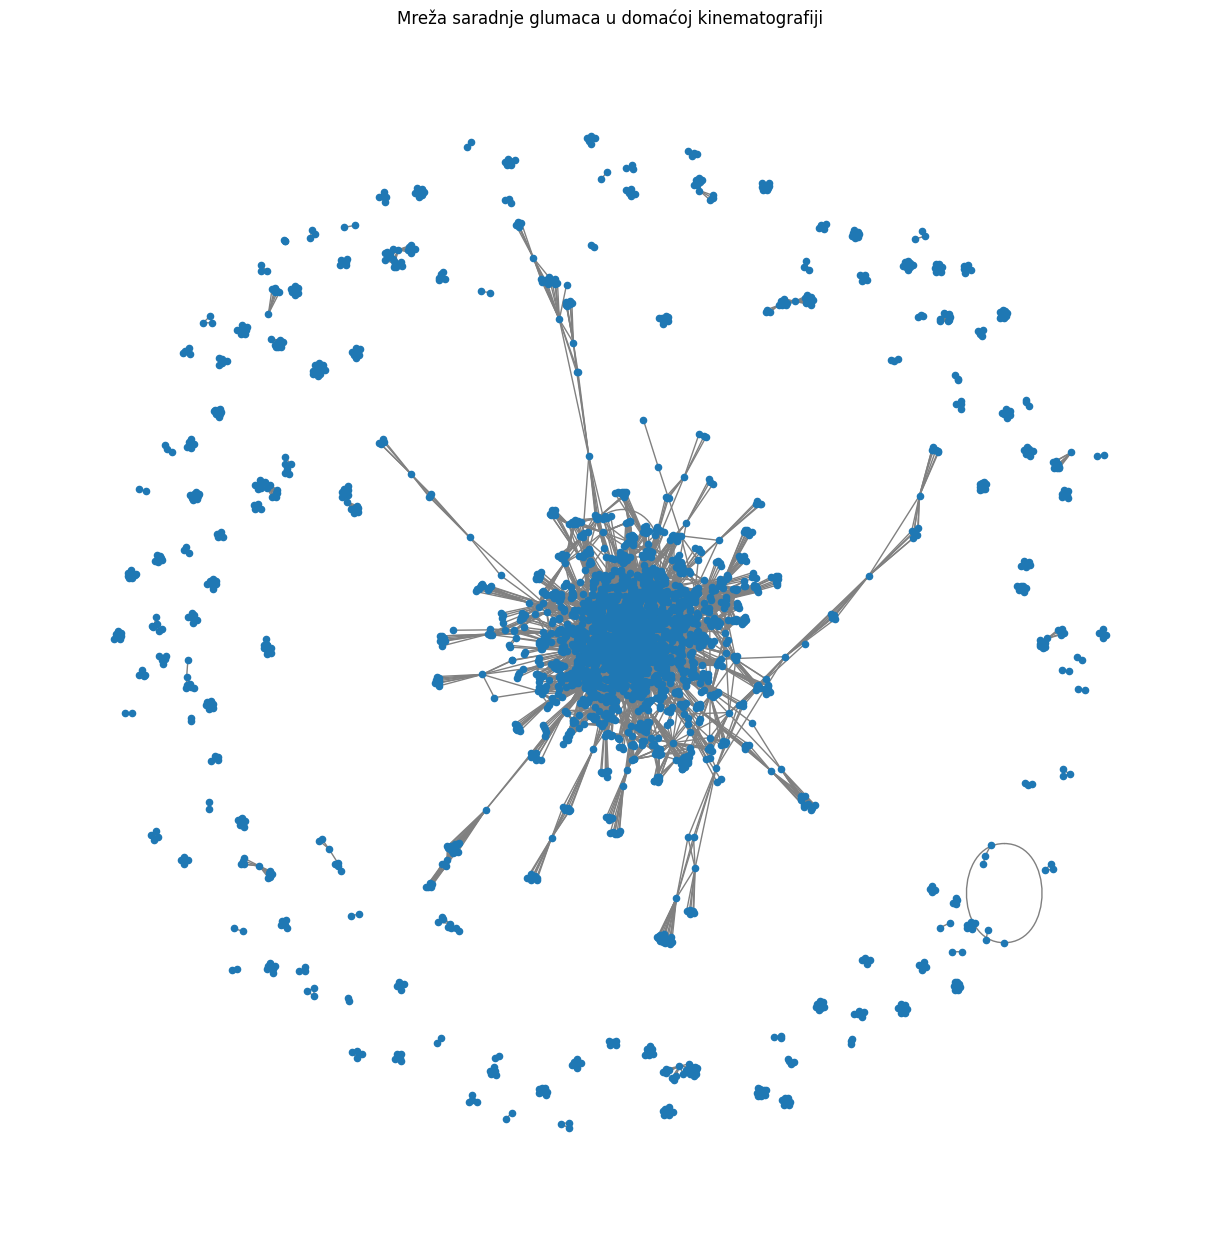

In [ ]:
# --------------------------------------------------
# VIZUALIZACIJA MREŽE
# --------------------------------------------------

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.15)

nx.draw(
    G,
    pos,
    node_size=20,
    edge_color="gray",
    with_labels=False
)
plt.title("Mreža saradnje glumaca u domaćoj kinematografiji")
plt.savefig(FIG_DIR / "mreza.png")
plt.show()


In [ ]:
# --------------------------------------------------
# DETEKCIJA ZAJEDNICA (Louvain)
# --------------------------------------------------
print("🔍 Pokrećem detekciju zajednica (Louvain)...")

# Pronalaženje zajednica (uzimajući u obzir težinu saradnje)
communities = nx_comm.louvain_communities(G, weight='weight', seed=42)

# Mapiranje: svakom glumcu dodeljujemo ID zajednice
community_map = {}
for i, comm in enumerate(communities):
    for actor_id in comm:
        community_map[actor_id] = i

# Dodajemo informaciju o zajednici u naš DataFrame sa metrikama
nodes_df['community'] = nodes_df['actor_id'].map(community_map)

print(f"✅ Pronađeno je {len(communities)} zajednica.")
print(nodes_df[['name', 'community']].head(10))

🔍 Pokrećem detekciju zajednica (Louvain)...
✅ Pronađeno je 164 zajednica.
                   name  community
0       Slavica Bajčeta       28.0
1      Natalija Ilinčić       28.0
2      Anton Augustinov       28.0
3     Danica Maksimović       28.0
4  Dunja Vladisavljević       28.0
5         Mila Drobnjak       28.0
6      Vasilije Zečević       28.0
7            Srna Vasić       28.0
8        Žarko Laušević        0.0
9          Jelena Đokić       32.0



📊 Analiza mrežnih metrika u toku...

🏆 Top 10 najuticajnijih glumaca (povezuju različite krugove):


,name,Uticaj (Betweenness),Povezanost (Degree),Bliskost (Closeness)
34,Svetozar Cvetković,0.037919,0.039600,0.272604
200,Petar Božović,0.029058,0.017395,0.243638
96,Tihomir Stanić,0.028162,0.037010,0.277049
42,Radoje Čupić,0.020596,0.032939,0.265271
17,Miodrag 'Miki' Krstović,0.018943,0.025167,0.258559
113,Igor Benčina,0.018409,0.027387,0.266021
115,Denis Murić,0.018321,0.030718,0.260662
40,Nebojša Dugalić,0.017796,0.025167,0.261241
41,Sloboda Mićalović,0.017704,0.026647,0.261823
99,Aleksandar Đurica,0.017288,0.030348,0.270046


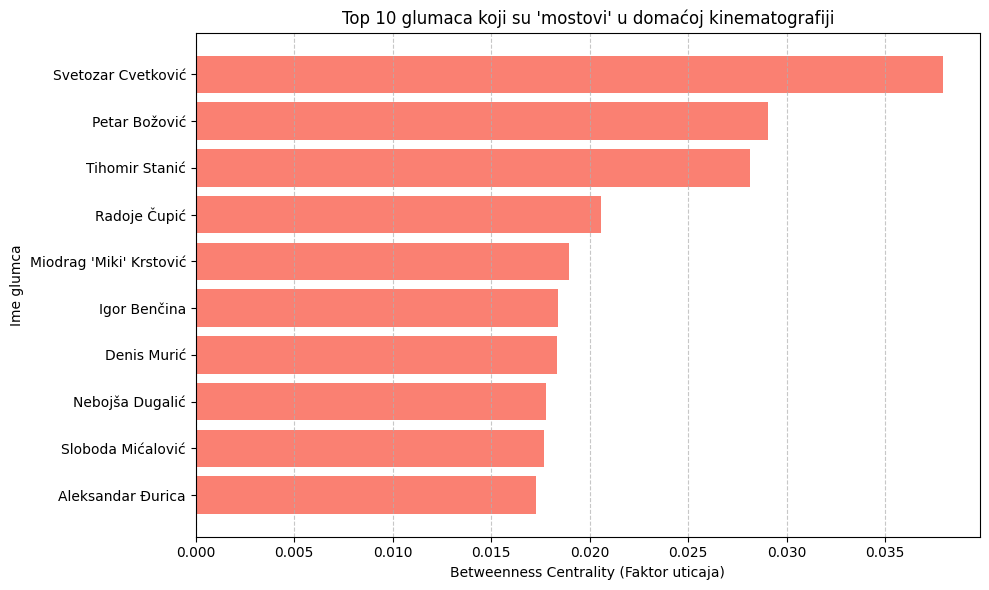


📈 Gustina mreže: 0.0035
To znači da je ostvareno 0.35% svih mogućih saradnji u ovoj grupi.


In [ ]:
# --------------------------------------------------
# VIZUALIZACIJA METRIKA
# --------------------------------------------------
print("\n📊 Analiza mrežnih metrika u toku...")

degree_cent = nx.degree_centrality(G)
betweenness_cent = nx.betweenness_centrality(G)
closeness_cent = nx.closeness_centrality(G)

# Pravljenje tabele za prikaz
metrics_df = pd.DataFrame({
    "actor_id": list(degree_cent.keys()),
    "Uticaj (Betweenness)": list(betweenness_cent.values()),
    "Povezanost (Degree)": list(degree_cent.values()),
    "Bliskost (Closeness)": list(closeness_cent.values())
})

# Spajanje sa imenima glumaca
metrics_df = metrics_df.merge(nodes_df, on="actor_id")
metrics_df = metrics_df.sort_values(by="Uticaj (Betweenness)", ascending=False)

# --- 1. PRIKAZ TABELE ---
print("\n🏆 Top 10 najuticajnijih glumaca (povezuju različite krugove):")
display(metrics_df[["name", "Uticaj (Betweenness)", "Povezanost (Degree)", "Bliskost (Closeness)"]].head(10))

# --- 2. GRAFIKON TOP 10 GLUMACA ---
plt.figure(figsize=(10, 6))
top_10_actors = metrics_df.head(10)
plt.barh(top_10_actors["name"], top_10_actors["Uticaj (Betweenness)"], color='salmon')
plt.xlabel("Betweenness Centrality (Faktor uticaja)")
plt.ylabel("Ime glumca")
plt.title("Top 10 glumaca koji su 'mostovi' u domaćoj kinematografiji")
plt.gca().invert_yaxis()  # Da najjači bude na vrhu
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Čuvanje slike u figures folder
plt.savefig(FIG_DIR / "top_actors_centrality.png")
plt.show()

# Čuvanje tabele u processed folder
metrics_df.to_csv(PROC_DIR / "network_metrics_complete.csv", index=False)

# --- 3. GLOBALNA STATISTIKA MREŽE ---
density = nx.density(G)
print(f"\n📈 Gustina mreže: {density:.4f}")
print(f"To znači da je ostvareno {density*100:.2f}% svih mogućih saradnji u ovoj grupi.")

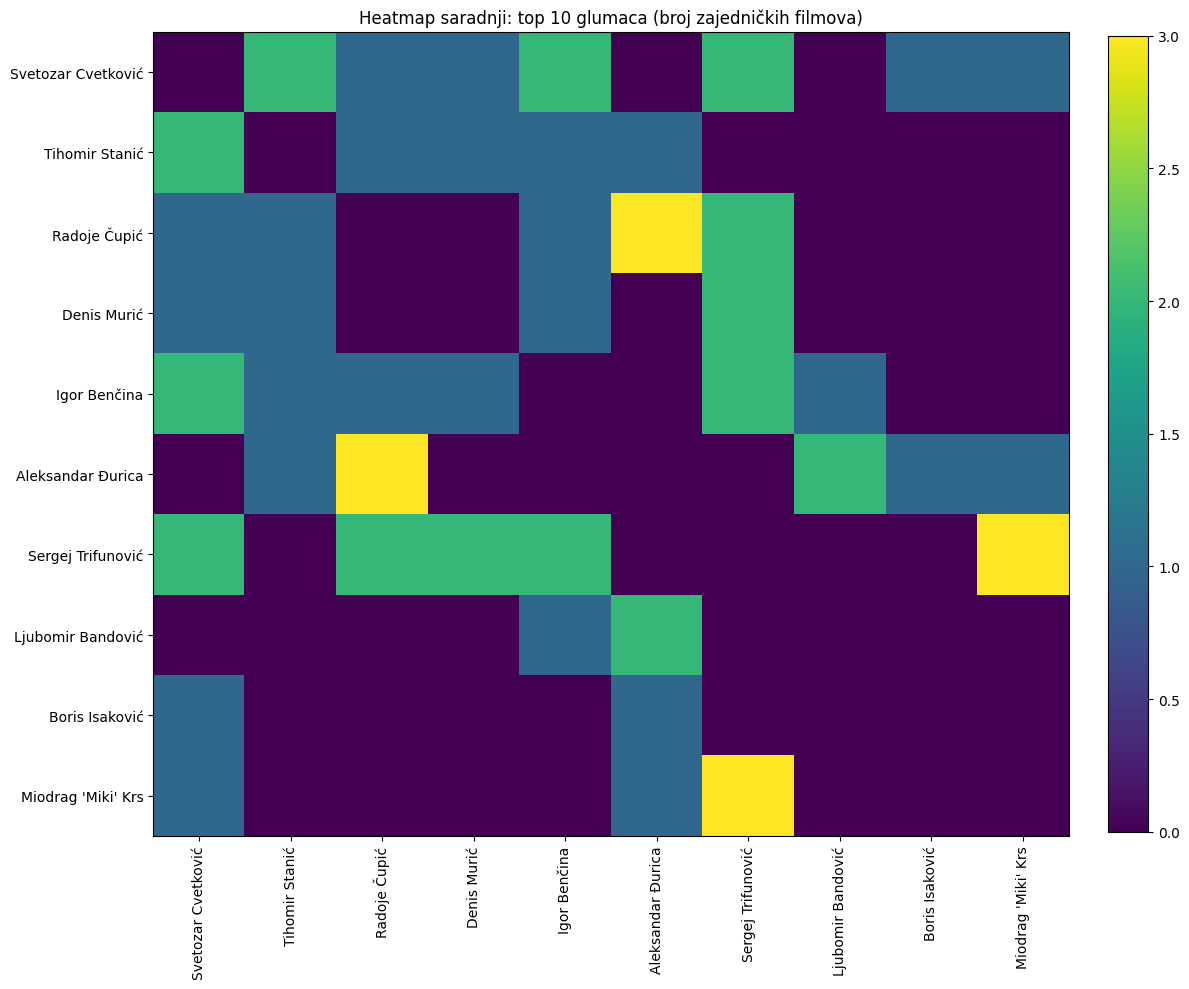

In [ ]:
# -----------------------------
# HEATMAP SARADNJI (TOP 10)
# -----------------------------
TOP_N = 10

all_ids = [aid for cast in movie_cast.values() for (aid, _) in cast]
counter = Counter(all_ids)
top_ids = [aid for aid, _ in counter.most_common(TOP_N)]

id_to_idx = {aid: i for i, aid in enumerate(top_ids)}
M = np.zeros((TOP_N, TOP_N), dtype=int)

for cast in movie_cast.values():
    ids = [aid for (aid, _) in cast if aid in id_to_idx]
    for i in range(len(ids)):
        for j in range(i+1, len(ids)):
            a = id_to_idx[ids[i]]
            b = id_to_idx[ids[j]]
            M[a, b] += 1
            M[b, a] += 1

actor_names = {aid: name for cast in movie_cast.values() for (aid, name) in cast}
labels = [actor_names.get(aid, str(aid))[:18] for aid in top_ids]

plt.figure(figsize=(12,10))
im = plt.imshow(M, interpolation='nearest', aspect='auto')
plt.colorbar(im, fraction=0.04, pad=0.04)
plt.xticks(range(TOP_N), labels, rotation=90)
plt.yticks(range(TOP_N), labels)
plt.title(f"Heatmap saradnji: top {TOP_N} glumaca (broj zajedničkih filmova)")
plt.tight_layout()
plt.savefig(FIG_DIR / "heatmap.png")
plt.show()



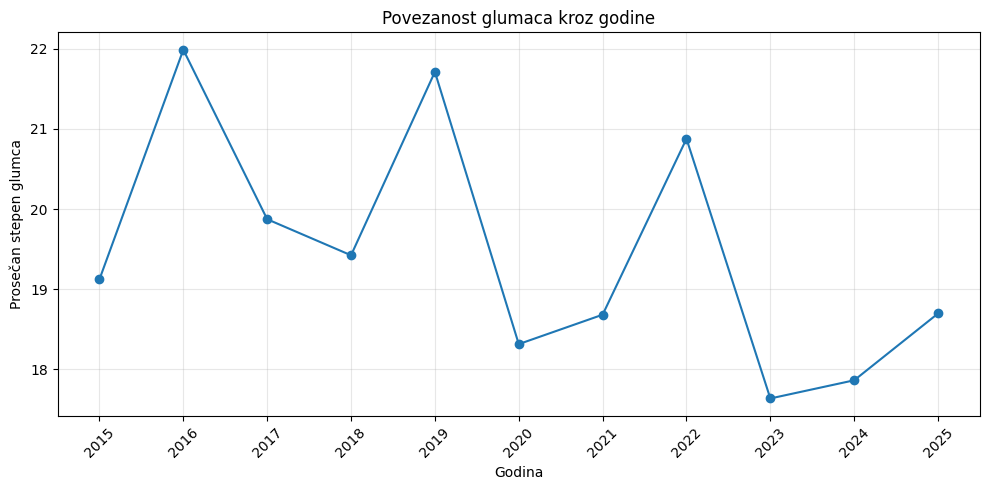

In [ ]:
# --------------------------------------------------
# PROSEČAN STEPEN GLUMACA PO GODINI
# --------------------------------------------------

year_degree = {y: [] for y in range(2015, 2026)}

movie_year = {
    m["id"]: pd.to_datetime(m.get("release_date"), errors="coerce").year
    for m in movies
}

for mid, cast in movie_cast.items():
    y = movie_year.get(mid)
    if y in year_degree:
        actor_ids = [a[0] for a in cast]
        for aid in actor_ids:
            if aid in G:
                year_degree[y].append(G.degree(aid))

avg_degree = {y: (sum(v)/len(v) if v else 0) for y, v in year_degree.items()}

plt.figure(figsize=(10,5))
plt.plot(avg_degree.keys(), avg_degree.values(), marker='o')
plt.xticks(range(2015, 2026), rotation=45)
plt.xlabel("Godina")
plt.ylabel("Prosečan stepen glumca")
plt.title("Povezanost glumaca kroz godine")
plt.savefig(FIG_DIR / "stepen_po_godini.png")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# --------------------------------------------------
# KREIRANJE DOKUMENTACIJE
# --------------------------------------------------

# 1. Kreiranje requirements.txt
requirements_content = """try:
    import networkx as nx
    import requests
except ImportError:
    !pip install networkx requests pandas matplotlib numpy

from networkx.algorithms import community as nx_comm
import requests
import json
import pandas as pd
import time
import shutil
from itertools import combinations
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import Counter
from pathlib import Path
from google.colab import files
import os
"""
with open("requirements.txt", "w") as f:
    f.write(requirements_content)
print("✅ Kreiran requirements.txt")

# 2. Kreiranje README.md
readme_content = """# Analiza saradnje glumaca u domaćoj kinematografiji (2015-2025)

Ovaj projekat analizira mrežu saradnje između glumaca u domaćim filmovima koristeći podatke sa TMDB API-ja.

## Struktura projekta
- /data_raw/ - Sirovi podaci preuzeti sa API-ja
- /data_processed/ - Obrađeni podaci (čvorovi i ivice)
- /notebooks/ - Jupyter Notebook sa kodom
- /figures/ - Generisani grafikoni i vizuelizacije
- README.md – opis projekta i uputstvo za pokretanje
- requirements.txt – spisak potrebnih biblioteka

## Pokretanje
Projekat je rađen u Google Colab okruženju. Potrebno je pokrenuti kod na Colabu klikom na Run all.
"""
with open("README.md", "w") as f:
    f.write(readme_content)
print("✅ Kreiran README.md")
zip_name = 'ADM_projekat_final.zip'
if os.path.exists(zip_name):
    os.remove(zip_name)
    print(f"🗑️ Obrisan stari {zip_name}")

print("💾 Čuvam kompletan kod u notebooks/ADM_Projekat.ipynb...")

try:
    %notebook notebooks/ADM_Projekat.ipynb
    print("✅ Kod je uspešno sačuvan u .ipynb formatu.")
except Exception as e:
    print(f"⚠️ Problem sa automatskim čuvanjem: {e}")

print("\n📦 Pakujem foldere: data_raw, data_processed, notebooks, figures")
!zip -r ADM_projekat_final.zip data_raw data_processed notebooks figures README.md requirements.txt

print("📥 Pokrećem download...")
files.download(zip_name)
print("🚀 SVE JE GOTOVO! ZIP je spreman.")

✅ Kreiran requirements.txt
✅ Kreiran README.md
🗑️ Obrisan stari ADM_projekat_final.zip
💾 Čuvam kompletan kod u notebooks/ADM_Projekat.ipynb...
✅ Kod je uspešno sačuvan u .ipynb formatu.

📦 Pakujem foldere: data_raw, data_processed, notebooks, figures
  adding: data_raw/ (stored 0%)
  adding: data_raw/movies_raw.csv (deflated 54%)
  adding: data_raw/movie_cast_raw.csv (deflated 69%)
  adding: data_processed/ (stored 0%)
  adding: data_processed/network_metrics_complete.csv (deflated 72%)
  adding: data_processed/edges.csv (deflated 78%)
  adding: data_processed/edges_weighted.csv (deflated 76%)
  adding: data_processed/actor_appearances.csv (deflated 64%)
  adding: data_processed/nodes.csv (deflated 58%)
  adding: notebooks/ (stored 0%)
  adding: notebooks/ADM_Projekat.ipynb (deflated 79%)
  adding: figures/ (stored 0%)
  adding: figures/heatmap.png (deflated 22%)
  adding: figures/stepen_po_godini.png (deflated 8%)
  adding: figures/histogram.png (deflated 27%)
  adding: figures/top_ac

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

🚀 SVE JE GOTOVO! ZIP je spreman.
